# Image segmentation with a U-Net-like architecture

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/03/20<br>
**Last modified:** 2020/04/20<br>
**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

## Download the data

In [1]:
#!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
#!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
#!tar -xf images.tar.gz
#!tar -xf annotations.tar.gz

## Prepare paths of input images and target segmentation masks

In [2]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 80

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


## Prepare `Sequence` class to load & vectorize batches of data

Version: latest-1043-g773bbcaa0
git-773bbcaa0,jerrybdev,2021-09-10T14:12:30+02:00 built 20210920_215223 by  on  ocialtra
Attempt to register kernel  AvgPoolingMeta<FP16[8]>@NEON with priority clashes (priority-wise) with the following kernels:  AvgPoolingMeta<FLOAT[4]>@NEON AvgPoolingMeta<INT8[32]>@NEON 
Attempt to register kernel  MaxPoolingMeta<FP16[8]>@NEON with priority clashes (priority-wise) with the following kernels:  MaxPoolingMeta<FLOAT[4]>@NEON MaxPoolingMeta<INT8[16]>@NEON 
Unknown DLS variable: DLS_ARM64 = "1"
AVX512_ENABLED: 0
DLS_PROCESS_MODE:  1
DLS_NUM_THREADS:  64
CPU_BIND:  1
MEM_BIND:  1
DLS_SUPERNODE 0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
PlatformInfo(vendor_id=3, cpu_family=8, cpu_model=3340, isa=NEON, L1=CacheInfo(size=65536, inclusive=1, share_count=1), L2=CacheInfo(size=1048576, inclusive=0, share_count=1), L3=CacheInfo(size=33554432, inclusive=0, share_count=80))


<span style='font-size:18.0pt'> Image Segmentation Batch Processing Throughput </span>

<span style='font-size:18.0pt'> Ampere Altra 1P (64 vCPU) </span>

<span style='font-size:15.0pt'> Total number of Images 3200 </span>

<span style='font-size:15.0pt'> Throughput 29.631677044290402 FPS </span>

Processig time 33747.66802787781 ms


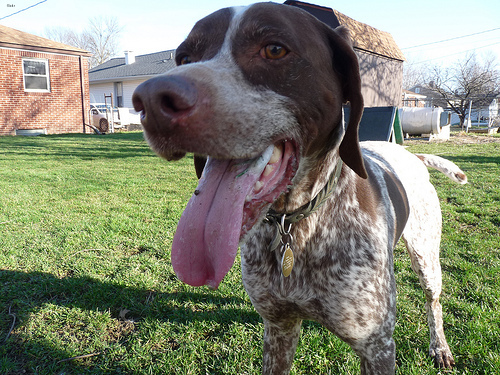

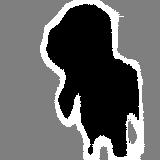

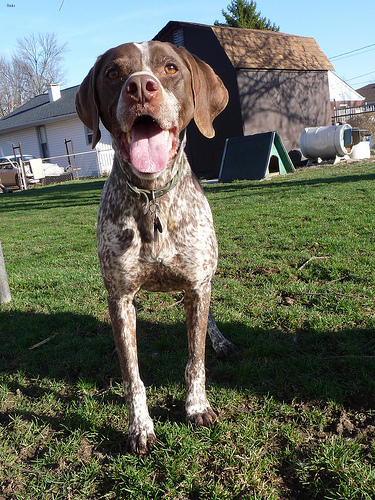

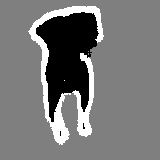

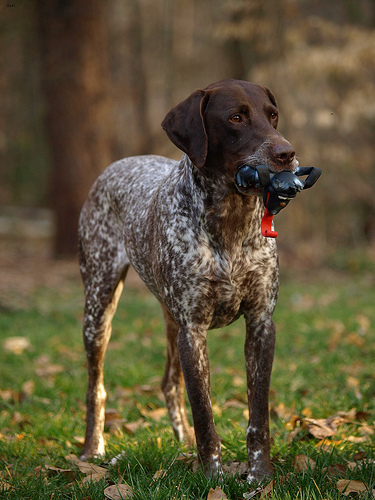

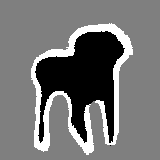

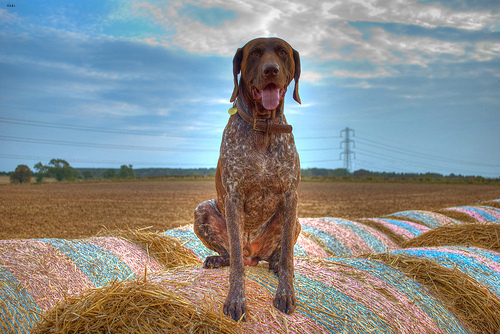

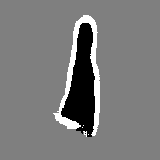

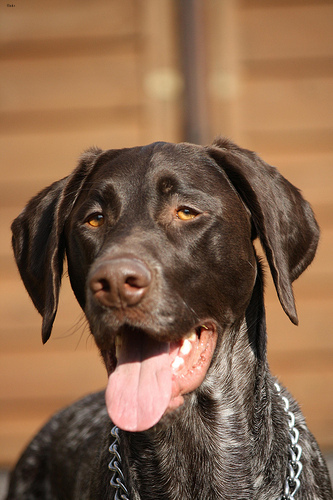

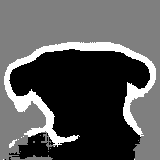

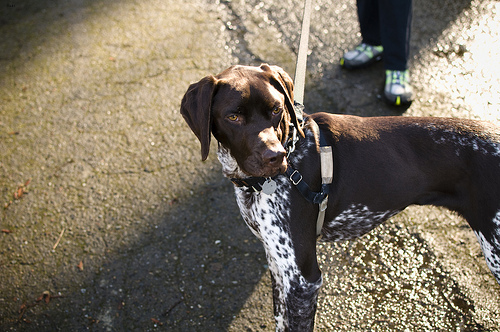

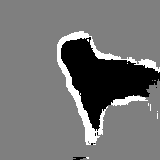

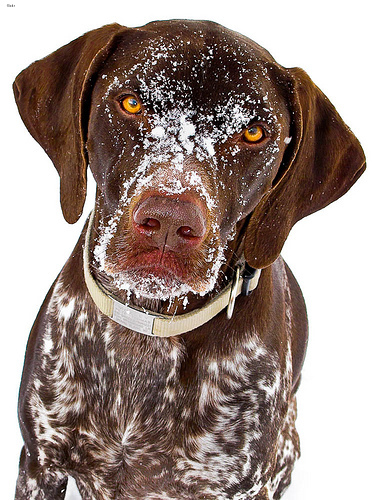

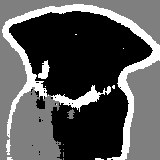

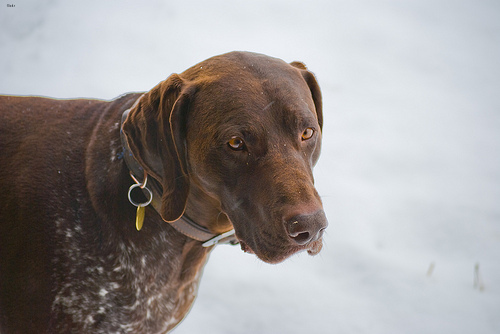

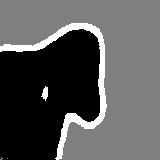

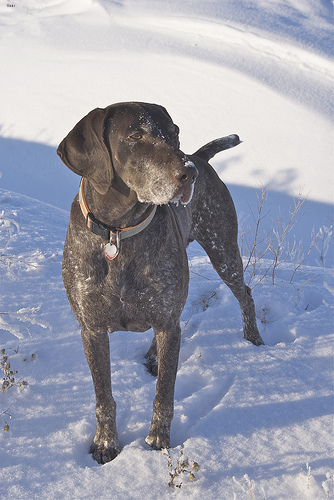

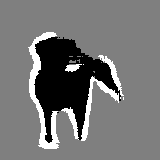

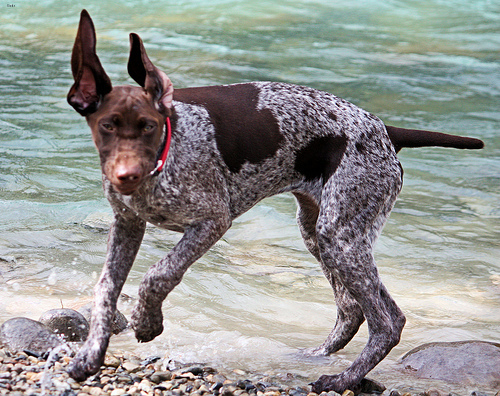

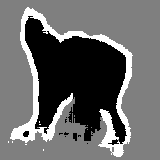

In [3]:
from IPython.display import Image, display, Markdown
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import tensorflow as tf

def printmd(string):
    display(Markdown(string))
    
num_threads = 64

config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=num_threads,  inter_op_parallelism_threads=1)
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y


import random

# Split our img paths into a training and a validation set
val_samples = 3200
#random.Random(1337).shuffle(input_img_paths)
#random.Random(1337).shuffle(target_img_paths)
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## Load pre-trained model

model = keras.models.load_model('oxford_segmentation.h5')

## Visualize predictions

# Generate predictions for all images in the validation set
import time

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
tf_model = tf.function(model)

t1 = time.time()
val_preds = model.predict(val_gen)
t2 = time.time()

printmd("<span style='font-size:18.0pt'> Image Segmentation Batch Processing Throughput </span>")
printmd("<span style='font-size:18.0pt'> Ampere Altra 1P ({} vCPU) </span>".format(num_threads))

printmd("<span style='font-size:15.0pt'> Total number of Images {} </span>".format(len(val_input_img_paths)))
printmd("<span style='font-size:15.0pt'> Throughput {} FPS </span>".format(1000 / (t2 - t1)))
print("Processig time {} ms".format((t2 - t1) * 1000))


def get_mask_image(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    return img

# Display the first 10 input images
for i in range(0, 10):
  orig_img = Image(filename=val_input_img_paths[i])
  mask_img = get_mask_image(i)
  display(orig_img)
  display(mask_img)